# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Importing the required libraries

import numpy as np
from imageio import imread
from skimage.transform import resize
import os
import datetime

import warnings
warnings.filterwarnings("ignore")

import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dropout

In [5]:
project_folder='datasets/Project_data'

In [6]:
# Plotting losses and accuarcies
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
class GenModel(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [21]:
class Conv3DModel_1(GenModel):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d_1=Conv3DModel_1()
conv_3d_1.initialize_path(project_folder)
conv_3d_1.initialize_image_properties(image_height=160,image_width=160)
conv_3d_1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
conv_3d_model_1=conv_3d_1.define_model()
conv_3d_model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_33 (Activation)  (None, 15, 80, 80, 32)   

##### Let's do some experiments to see how training time is affected by number of images in sequence, batch size, and resolution

In [24]:
conv_3d_tt1=Conv3DModel_1()
conv_3d_tt1.initialize_path(project_folder)
conv_3d_tt1.initialize_image_properties(image_height=160,image_width=160)
conv_3d_tt1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d_model_tt1=conv_3d_tt1.define_model()
print("Total Params:", conv_3d_model_tt1.count_params())
conv_3d_tt1.train_model(conv_3d_model_tt1)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5422 - categorical_accuracy: 0.4268
Epoch 00001: saving model to model_init_2023-02-1207_46_21.095711/model-00001-1.54220-0.42685-2.05031-0.20000.h5
23/23 [==============================] - 100s 4s/step - loss: 1.5422 - categorical_accuracy: 0.4268 - val_loss: 2.0503 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.9338 - categorical_accuracy: 0.6335
Epoch 00002: saving model to model_init_2023-02-1207_46_21.095711/model-00002-0.93378-0.63348-3.54832-0.19000.h5
23/23 [==============================] - 98s 4s/step - loss: 0.9338 - categorical_accuracy: 0.6335 - val_loss: 3.5483 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.7862 - categorical_accuracy: 0.6772
Epoch 00003: saving model to model_init_2023-02-1207_46_21.095711/model-00003-0.78621-0.67722-4.29973-0.

In [25]:
conv_3d_tt2=Conv3DModel_1()
conv_3d_tt2.initialize_path(project_folder)
conv_3d_tt2.initialize_image_properties(image_height=160,image_width=160)
conv_3d_tt2.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d_model_tt2=conv_3d_tt2.define_model()
print("Total Params:", conv_3d_model_tt2.count_params())
conv_3d_tt2.train_model(conv_3d_model_tt2)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5157 - categorical_accuracy: 0.4314
Epoch 00001: saving model to model_init_2023-02-1207_57_12.308558/model-00001-1.51574-0.43137-2.94048-0.21000.h5
45/45 [==============================] - 189s 4s/step - loss: 1.5157 - categorical_accuracy: 0.4314 - val_loss: 2.9405 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9661 - categorical_accuracy: 0.6124
Epoch 00002: saving model to model_init_2023-02-1207_57_12.308558/model-00002-0.96606-0.61237-4.36158-0.20000.h5
45/45 [==============================] - 194s 4s/step - loss: 0.9661 - categorical_accuracy: 0.6124 - val_loss: 4.3616 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [26]:
conv_3d_tt3=Conv3DModel_1()
conv_3d_tt3.initialize_path(project_folder)
conv_3d_tt3.initialize_image_properties(image_height=160,image_width=160)
conv_3d_tt3.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d_model_tt3=conv_3d_tt3.define_model()
print("Total Params:", conv_3d_model_tt3.count_params())
conv_3d_tt3.train_model(conv_3d_model_tt3)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.6142 - categorical_accuracy: 0.4148
Epoch 00001: saving model to model_init_2023-02-1208_07_35.307871/model-00001-1.61421-0.41478-3.07987-0.16000.h5
17/17 [==============================] - 100s 6s/step - loss: 1.6142 - categorical_accuracy: 0.4148 - val_loss: 3.0799 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.8650 - categorical_accuracy: 0.6727
Epoch 00002: saving model to model_init_2023-02-1208_07_35.307871/model-00002-0.86503-0.67270-5.65622-0.20000.h5
17/17 [==============================] - 98s 6s/step - loss: 0.8650 - categorical_accuracy: 0.6727 - val_loss: 5.6562 - val_categorical_accuracy: 0.2000 - lr: 0.0010


In [27]:
conv_3d_tt4=Conv3DModel_1()
conv_3d_tt4.initialize_path(project_folder)
conv_3d_tt4.initialize_image_properties(image_height=100,image_width=100)
conv_3d_tt4.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d_model_tt4=conv_3d_tt4.define_model()
print("Total Params:", conv_3d_model_tt4.count_params())
conv_3d_tt4.train_model(conv_3d_model_tt4)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.4783 - categorical_accuracy: 0.4419
Epoch 00001: saving model to model_init_2023-02-1208_12_51.927845/model-00001-1.47831-0.44193-2.48857-0.21000.h5
23/23 [==============================] - 166s 7s/step - loss: 1.4783 - categorical_accuracy: 0.4419 - val_loss: 2.4886 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.9301 - categorical_accuracy: 0.6365
Epoch 00002: saving model to model_init_2023-02-1208_12_51.927845/model-00002-0.93007-0.63650-4.25273-0.17000.h5
23/23 [==============================] - 161s 7s/step - loss: 0.9301 - categorical_accuracy: 0.6365 - val_loss: 4.2527 - val_categorical_accuracy: 0.1700 - lr: 0.0010


In [28]:
conv_3d_tt5=Conv3DModel_1()
conv_3d_tt5.initialize_path(project_folder)
conv_3d_tt5.initialize_image_properties(image_height=100,image_width=100)
conv_3d_tt5.initialize_hyperparams(frames_to_sample=16,batch_size=80,num_epochs=2)
conv_3d_model_tt5=conv_3d_tt5.define_model()
print("Total Params:", conv_3d_model_tt5.count_params())
conv_3d_tt5.train_model(conv_3d_model_tt5)

Total Params: 687813
Epoch 1/2
9/9 [==============================] - ETA: 0s - loss: 1.7315 - categorical_accuracy: 0.3816 
Epoch 00001: saving model to model_init_2023-02-1208_21_49.549389/model-00001-1.73148-0.38160-1.63860-0.21000.h5
9/9 [==============================] - 112s 14s/step - loss: 1.7315 - categorical_accuracy: 0.3816 - val_loss: 1.6386 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
9/9 [==============================] - ETA: 0s - loss: 1.0799 - categorical_accuracy: 0.6033
Epoch 00002: saving model to model_init_2023-02-1208_21_49.549389/model-00002-1.07991-0.60332-1.97544-0.14000.h5
9/9 [==============================] - 88s 11s/step - loss: 1.0799 - categorical_accuracy: 0.6033 - val_loss: 1.9754 - val_categorical_accuracy: 0.1400 - lr: 0.0010


In [30]:
conv_3d_tt6=Conv3DModel_1()
conv_3d_tt6.initialize_path(project_folder)
conv_3d_tt6.initialize_image_properties(image_height=100,image_width=100)
conv_3d_tt6.initialize_hyperparams(frames_to_sample=16,batch_size=15,num_epochs=2)
conv_3d_model_tt6=conv_3d_tt6.define_model()
print("Total Params:", conv_3d_model_tt6.count_params())
conv_3d_tt6.train_model(conv_3d_model_tt6)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.5238 - categorical_accuracy: 0.4449
Epoch 00001: saving model to model_init_2023-02-1208_38_38.980078/model-00001-1.52375-0.44495-3.76513-0.16000.h5
45/45 [==============================] - 88s 2s/step - loss: 1.5238 - categorical_accuracy: 0.4449 - val_loss: 3.7651 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.9805 - categorical_accuracy: 0.6169
Epoch 00002: saving model to model_init_2023-02-1208_38_38.980078/model-00002-0.98051-0.61689-8.74291-0.15000.h5
45/45 [==============================] - 87s 2s/step - loss: 0.9805 - categorical_accuracy: 0.6169 - val_loss: 8.7429 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [31]:
conv_3d_tt7=Conv3DModel_1()
conv_3d_tt7.initialize_path(project_folder)
conv_3d_tt7.initialize_image_properties(image_height=100,image_width=100)
conv_3d_tt7.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d_model_tt7=conv_3d_tt7.define_model()
print("Total Params:", conv_3d_model_tt7.count_params())
conv_3d_tt7.train_model(conv_3d_model_tt7)

Total Params: 687813
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.7010 - categorical_accuracy: 0.3922
Epoch 00001: saving model to model_init_2023-02-1208_44_46.768229/model-00001-1.70100-0.39216-7.09376-0.14000.h5
67/67 [==============================] - 87s 1s/step - loss: 1.7010 - categorical_accuracy: 0.3922 - val_loss: 7.0938 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.1446 - categorical_accuracy: 0.5520
Epoch 00002: saving model to model_init_2023-02-1208_44_46.768229/model-00002-1.14456-0.55204-9.44038-0.17000.h5
67/67 [==============================] - 88s 1s/step - loss: 1.1446 - categorical_accuracy: 0.5520 - val_loss: 9.4404 - val_categorical_accuracy: 0.1700 - lr: 0.0010


##### Here, we can observe the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size

# Model 1
### Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [16]:
class Conv3DModel_Base1(GenModel):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d_base1=Conv3DModel_Base1()
conv_3d_base1.initialize_path(project_folder)
conv_3d_base1.initialize_image_properties(image_height=160,image_width=160)
conv_3d_base1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d_model_base1=conv_3d_base1.define_model()
conv_3d_model_base1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_5 (Activation)   (None, 10, 80, 80, 32)   

In [20]:
print("Total Params:", conv_3d_model_base1.count_params())
history_model_base1 = conv_3d_base1.train_model(conv_3d_model_base1)

Total Params: 1117061
Epoch 1/15


2023-02-12 10:14:03.053218: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.4931 - categorical_accuracy: 0.4389
Epoch 00001: saving model to model_init_2023-02-1210_13_54.367846/model-00001-1.49309-0.43891-1.70041-0.17000.h5
17/17 [==============================] - 124s 7s/step - loss: 1.4931 - categorical_accuracy: 0.4389 - val_loss: 1.7004 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9704 - categorical_accuracy: 0.6109
Epoch 00002: saving model to model_init_2023-02-1210_13_54.367846/model-00002-0.97036-0.61086-2.12544-0.20000.h5
17/17 [==============================] - 124s 8s/step - loss: 0.9704 - categorical_accuracy: 0.6109 - val_loss: 2.1254 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6451 - categorical_accuracy: 0.7451
Epoch 00003: saving model to model_init_2023-02-1210_13_54.367846/model-00003-0.64511-0.74510-2.57019-0.21000.h5
17/17 [=============

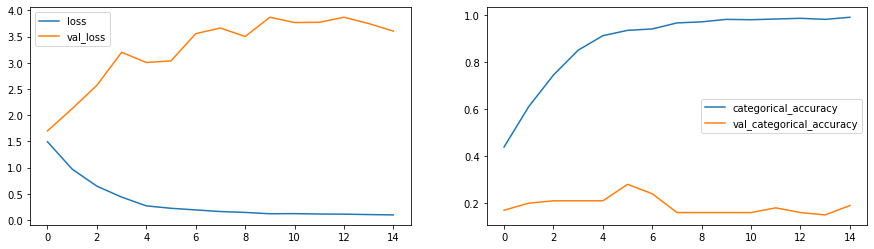

In [21]:
plot(history_model_base1)

### Here, we can observe the model is clearly overfitting and there is no improvement in increase of epochs so we now try for CNN LSTM model and see the train and validation accuracies for them so that we can increase or decrease the augmentation accordingly and we try to include the dropout of 25% to address overfitting of model and increase the epochs for better results.

### Now Let' try for CNN LSTM model and see the train and val accuracies for them so that we can increase or decrease the augmentation

# Model 2 - CNN- LSTM Model

In [8]:
class RNNCNN1(GenModel):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
rnn_cnn_1=RNNCNN1()
rnn_cnn_1.initialize_path(project_folder)
rnn_cnn_1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn_model_1=rnn_cnn_1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_model_1.summary()

2023-02-13 05:58:19.867116: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-13 05:58:19.867202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

In [10]:
print("Total Params:", rnn_cnn_model_1.count_params())
history_model_2=rnn_cnn_1.train_model(rnn_cnn_model_1,augment_data=True)

Total Params: 1657445
Epoch 1/20


2023-02-13 05:58:32.411845: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.4463 - categorical_accuracy: 0.3793
Epoch 00001: saving model to model_init_2023-02-1305_58_21.626621/model-00001-1.44632-0.37934-1.66104-0.20000.h5
34/34 [==============================] - 208s 6s/step - loss: 1.4463 - categorical_accuracy: 0.3793 - val_loss: 1.6610 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0804 - categorical_accuracy: 0.5830
Epoch 00002: saving model to model_init_2023-02-1305_58_21.626621/model-00002-1.08043-0.58296-2.04491-0.24000.h5
34/34 [==============================] - 202s 6s/step - loss: 1.0804 - categorical_accuracy: 0.5830 - val_loss: 2.0449 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9068 - categorical_accuracy: 0.6561
Epoch 00003: saving model to model_init_2023-02-1305_58_21.626621/model-00003-0.90679-0.65611-1.95878-0.26000.h5
34/34 [=============

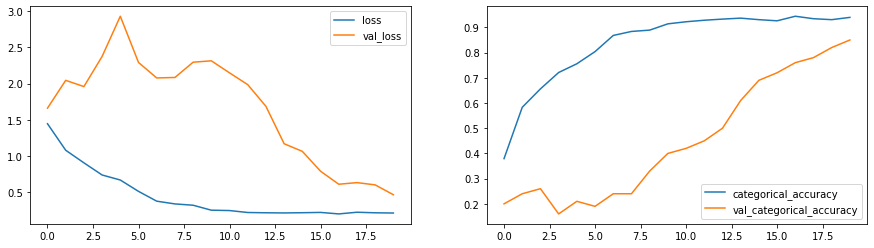

In [11]:
plot(history_model_2)

### Here we achieved a good training accuracy of 93.9% and the validation accuracy of 85.0%.
- But there is a lot of difference between training and validation accuracy so let’s increase the augmentation and further train the models with different metrices

# Increaced Augmentation

In [8]:
class GenModelAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model 3
#### (3,3,3) Filter with 160x160 Image resolution

In [13]:
class Conv3DModel_3(GenModelAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d_3=Conv3DModel_3()
conv_3d_3.initialize_path(project_folder)
conv_3d_3.initialize_image_properties(image_height=160,image_width=160)
conv_3d_3.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d_model3=conv_3d_3.define_model(dense_neurons=256,dropout=0.5)
conv_3d_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 20, 160, 160, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)   

In [15]:
print("Total Params:", conv_3d_model3.count_params())
history_model3=conv_3d_3.train_model(conv_3d_model3,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9609 - categorical_accuracy: 0.3552
Epoch 00001: saving model to model_init_2023-02-1307_04_35.735127/model-00001-1.96091-0.35520-2.73022-0.16000.h5
34/34 [==============================] - 229s 7s/step - loss: 1.9609 - categorical_accuracy: 0.3552 - val_loss: 2.7302 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4586 - categorical_accuracy: 0.5000
Epoch 00002: saving model to model_init_2023-02-1307_04_35.735127/model-00002-1.45865-0.50000-4.03090-0.15000.h5
34/34 [==============================] - 231s 7s/step - loss: 1.4586 - categorical_accuracy: 0.5000 - val_loss: 4.0309 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.1886 - categorical_accuracy: 0.5777
Epoch 00003: saving model to model_init_2023-02-1307_04_35.735127/model-00003-1.18857-0.5776

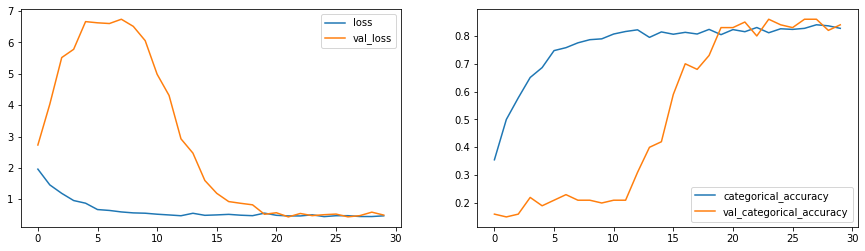

In [16]:
plot(history_model3)

### Here the model has training accuracy of 82.7% and the validation accuracy of 84.0%.

### Here at one instance of epoch both training and validation accuracies got equal and suddenly validation accuracy got increased than train accuracy which is not desirable.
### So, lets try to decrease the image size and increase the batch size and observe the loss and accuracies further.

# Model 4
### (3,3,3) Filter  with 120x120 Image resolution

In [22]:
class Conv3DModel_4(GenModelAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d_4=Conv3DModel_4()
conv_3d_4.initialize_path(project_folder)
conv_3d_4.initialize_image_properties(image_height=120,image_width=120)
conv_3d_4.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d_model_4=conv_3d_4.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d_model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

2023-02-12 14:27:54.812309: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-12 14:27:54.812397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [26]:
print("Total Params:", conv_3d_model_4.count_params())
history_model_4=conv_3d_4.train_model(conv_3d_model_4,augment_data=True)

Total Params: 1762613
Epoch 1/30


2023-02-12 14:28:42.845260: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.0727 - categorical_accuracy: 0.3386
Epoch 00001: saving model to model_init_2023-02-1214_28_34.700759/model-00001-2.07273-0.33861-1.91073-0.16000.h5
23/23 [==============================] - 164s 7s/step - loss: 2.0727 - categorical_accuracy: 0.3386 - val_loss: 1.9107 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5837 - categorical_accuracy: 0.4744
Epoch 00002: saving model to model_init_2023-02-1214_28_34.700759/model-00002-1.58366-0.47436-3.04539-0.17000.h5
23/23 [==============================] - 157s 7s/step - loss: 1.5837 - categorical_accuracy: 0.4744 - val_loss: 3.0454 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2662 - categorical_accuracy: 0.5596
Epoch 00003: saving model to model_init_2023-02-1214_28_34.700759/model-00003-1.26620-0.55958-4.38974-0.15000.h5
23/23 [=====

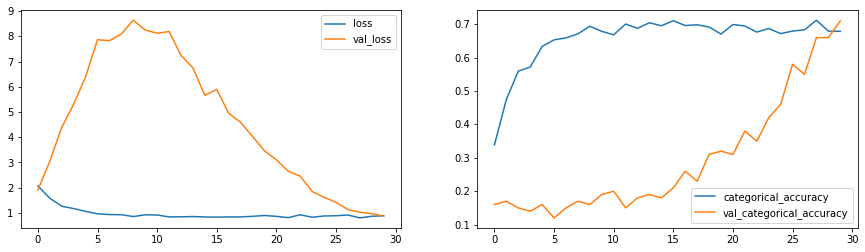

In [27]:
plot(history_model_4)

### Here the model has training accuracy of 67.7% and the validation accuracy of 71.0%.

### Here, we used the filter with (3,3,3) and decreased the image size. We can see both the accuracies are very near but less.

### So, let’s try to reduce the number of network parameters and slightly decrease the batch size, epochs. Now observe the loss and accuracies further.

# Model 5
### Reducing network parameters

In [9]:
class Conv3DModel_5(GenModelAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d_5=Conv3DModel_5()
conv_3d_5.initialize_path(project_folder)
conv_3d_5.initialize_image_properties(image_height=120,image_width=120)
conv_3d_5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d_model_5=conv_3d_5.define_model(dense_neurons=64,dropout=0.25)
conv_3d_model_5.summary()

2023-02-13 10:44:24.830840: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-13 10:44:24.830938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_1 (Activation)   (None, 8, 60, 60, 32)     0

In [11]:
print("Total Params:", conv_3d_model_5.count_params())
history_model_5=conv_3d_5.train_model(conv_3d_model_5,augment_data=True)

Total Params: 504709
Epoch 1/25


2023-02-13 10:44:41.972994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.8040 - categorical_accuracy: 0.3401
Epoch 00001: saving model to model_init_2023-02-1310_44_35.989925/model-00001-1.80404-0.34012-2.02313-0.21000.h5
34/34 [==============================] - 159s 5s/step - loss: 1.8040 - categorical_accuracy: 0.3401 - val_loss: 2.0231 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2585 - categorical_accuracy: 0.5030
Epoch 00002: saving model to model_init_2023-02-1310_44_35.989925/model-00002-1.25854-0.50302-2.77183-0.20000.h5
34/34 [==============================] - 151s 5s/step - loss: 1.2585 - categorical_accuracy: 0.5030 - val_loss: 2.7718 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0964 - categorical_accuracy: 0.5792
Epoch 00003: saving model to model_init_2023-02-1310_44_35.989925/model-00003-1.09640-0.57919-3.89721-0.26000.h5
34/34 [=====

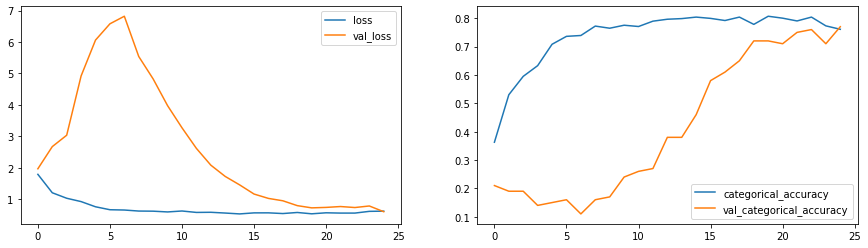

In [24]:
plot(history_model_5)

### Here the model has training accuracy of 76.62% and the validation accuracy of 76.0%.

### Here, we used the filter with (3,3,3). We can see both the accuracies are very near and observes pretty good but low in percentages

### So, let’s try CNN LSTM with GRU models.

# Model 6
## CNN LSTM with GRU

In [33]:
class RNNCNN2(GenModelAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [34]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [35]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model6=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4977 - categorical_accuracy: 0.3673
Epoch 00001: saving model to model_init_2023-02-1216_59_07.459936/model-00001-1.49774-0.36727-1.62120-0.24000.h5
34/34 [==============================] - 180s 5s/step - loss: 1.4977 - categorical_accuracy: 0.3673 - val_loss: 1.6212 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0050 - categorical_accuracy: 0.6078
Epoch 00002: saving model to model_init_2023-02-1216_59_07.459936/model-00002-1.00500-0.60784-1.96049-0.21000.h5
34/34 [==============================] - 177s 5s/step - loss: 1.0050 - categorical_accuracy: 0.6078 - val_loss: 1.9605 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8032 - categorical_accuracy: 0.7006
Epoch 00003: saving model to model_init_2023-02-1216_59_07.459936/model-00003-0.80316-0.7006

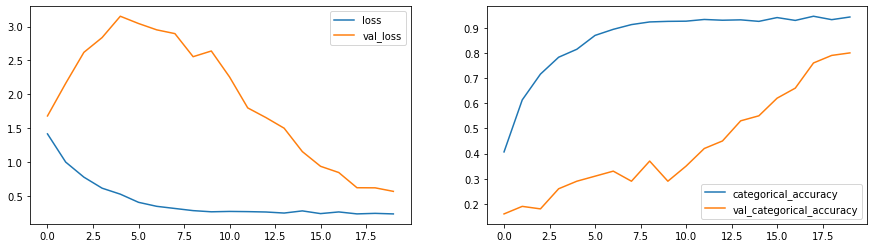

In [41]:
plot(history_model6)

### Here we achieved a good training accuracy of 93.36% and the validation accuracy of 77.0%.

### But there is a lot of difference between training and validation accuracy. As we tried many different combinations, but we are not getting perfect results. 

### So, let’s try Transfer learning which many provide us with best results

# Model 7
## Transfer Learning

In [16]:
from keras.applications import mobilenet

In [17]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(GenModelAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
rnn_cnn_t_l=RNNCNN_TL()
rnn_cnn_t_l.initialize_path(project_folder)
rnn_cnn_t_l.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_t_l.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_t_model_1=rnn_cnn_t_l.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_t_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)              

In [19]:
print("Total Params:", rnn_cnn_t_model_1.count_params())
history_model_7=rnn_cnn_t_l.train_model(rnn_cnn_t_model_1,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3383 - categorical_accuracy: 0.4487
Epoch 00001: saving model to model_init_2023-02-1302_10_43.519240/model-00001-1.33826-0.44872-0.84032-0.71000.h5
133/133 [==============================] - 166s 1s/step - loss: 1.3383 - categorical_accuracy: 0.4487 - val_loss: 0.8403 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8281 - categorical_accuracy: 0.6870
Epoch 00002: saving model to model_init_2023-02-1302_10_43.519240/model-00002-0.82810-0.68703-0.68191-0.74000.h5
133/133 [==============================] - 163s 1s/step - loss: 0.8281 - categorical_accuracy: 0.6870 - val_loss: 0.6819 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.5844 - categorical_accuracy: 0.7911
Epoch 00003: saving model to model_init_2023-02-1302_10_43.519240/model-00003-0.58436-0.79

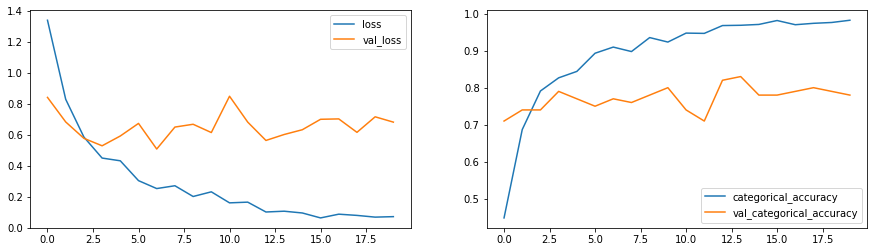

In [20]:
plot(history_model_7)

##### Here we achieved a good training accuracy of 98.19% and the validation accuracy of 78.0%. 
- Trainable params: 609,541
- Non-trainable params: 3,230,912
#### Here, there is a lot of difference between training and validation accuracy. In this model the untrained parameters count is 3,230,912 which very huge and if we try to train all the parameters then we can achieve best results

### So, let’s try Transfer learning with all parameters trained which many provide us with best results

# Model 8
### Transfer Learning with GRU and training all weights

In [12]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(GenModelAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = tf.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

2023-02-13 01:14:53.218082: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-13 01:14:53.218148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [13]:
rnn_cnn_tl_2=RNNCNN_TL2()
rnn_cnn_tl_2.initialize_path(project_folder)
rnn_cnn_tl_2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl_2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model_2=rnn_cnn_tl_2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)               4

In [14]:
print("Total Params:", rnn_cnn_tl_model_2.count_params())
history_model8=rnn_cnn_tl_2.train_model(rnn_cnn_tl_model_2,augment_data=True)

Total Params: 3693253
Epoch 1/20


2023-02-13 01:16:00.553330: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 1.0824 - categorical_accuracy: 0.5777
Epoch 00001: saving model to model_init_2023-02-1301_15_54.772821/model-00001-1.08236-0.57768-0.55248-0.80000.h5
133/133 [==============================] - 164s 1s/step - loss: 1.0824 - categorical_accuracy: 0.5777 - val_loss: 0.5525 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.4828 - categorical_accuracy: 0.8348
Epoch 00002: saving model to model_init_2023-02-1301_15_54.772821/model-00002-0.48282-0.83484-0.23706-0.92000.h5
133/133 [==============================] - 153s 1s/step - loss: 0.4828 - categorical_accuracy: 0.8348 - val_loss: 0.2371 - val_categorical_accuracy: 0.9200 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2245 - categorical_accuracy: 0.9291
Epoch 00006: saving model to model_init_2023-02-1301_15_54.772821/model-00006-0.22450-0.92911-0.35046-0.84000.h5
133/133 [=

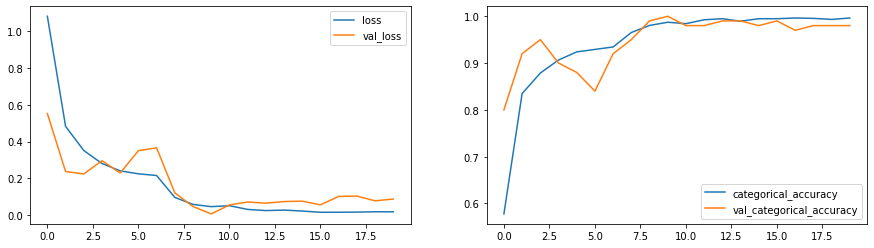

In [15]:
plot(history_model8)

### Here we achieved a good training accuracy of 99.62%  and the validation accuracy of 98.0%.
- Trainable params: 3,669,317
- Non-trainable params: 23,936

### Finally, We found the best model!!!

### -----------------------------------*****---------END---------*****---------------------------------